Завдання 1. Оптимізація доступу до даних за допомогою LRU-кешу

In [25]:
import random
import time
from functools import lru_cache
from collections import OrderedDict

# Задані параметри завдання
ARRAY_SIZE = 100_000
NUM_QUERIES = 50_000
CACHE_SIZE = 1000

# Генерація масиву
array = [random.randint(1, 100) for _ in range(ARRAY_SIZE)]

# Генерація запитів з імітацією повторюваності
queries = []
range_cache = []

for _ in range(NUM_QUERIES):
    if random.random() < 0.5:  # 50% повторювані
        if range_cache:
            queries.append(random.choice(range_cache))
        else:
            L, R = sorted(random.sample(range(ARRAY_SIZE), 2))
            q = ('Range', L, R)
            range_cache.append(q)
            queries.append(q)
    else:
        if random.random() < 0.7:
            L, R = sorted(random.sample(range(ARRAY_SIZE), 2))
            q = ('Range', L, R)
            range_cache.append(q)
            queries.append(q)
        else:
            idx = random.randint(0, ARRAY_SIZE - 1)
            val = random.randint(1, 100)
            queries.append(('Update', idx, val))

# Клас LRU-кеш реалізація
class LRUCache:
    def __init__(self, capacity):
        self.cache = OrderedDict()
        self.capacity = capacity

    def get(self, key):
        if key in self.cache:
            self.cache.move_to_end(key)
            return self.cache[key]
        return None

    def put(self, key, value):
        if key in self.cache:
            self.cache.move_to_end(key)
        self.cache[key] = value
        if len(self.cache) > self.capacity:
            self.cache.popitem(last=False)

    def invalidate(self, index):
        keys_to_remove = [key for key in self.cache if key[0] <= index <= key[1]]
        for key in keys_to_remove:
            del self.cache[key]

# Функції "Без кешу"
def range_sum_no_cache(array, L, R):
    return sum(array[L:R+1])

def update_no_cache(array, index, value):
    array[index] = value

# Функції "З кешем"
lru_cache_obj = LRUCache(CACHE_SIZE)

def range_sum_with_cache(array, L, R):
    cached = lru_cache_obj.get((L, R))
    if cached is not None:
        return cached
    total = sum(array[L:R+1])
    lru_cache_obj.put((L, R), total)
    return total

def update_with_cache(array, index, value):
    array[index] = value
    lru_cache_obj.invalidate(index)

# Тестування
def run_test(use_cache=False):
    test_array = array.copy()
    start_time = time.time()
    for q in queries:
        if q[0] == 'Range':
            if use_cache:
                range_sum_with_cache(test_array, q[1], q[2])
            else:
                range_sum_no_cache(test_array, q[1], q[2])
        elif q[0] == 'Update':
            if use_cache:
                update_with_cache(test_array, q[1], q[2])
            else:
                update_no_cache(test_array, q[1], q[2])
    return time.time() - start_time

# Запуск та виведення результатів
no_cache_time = run_test(use_cache=False)
cache_time = run_test(use_cache=True)

print(f"\nЧас виконання без кешування: {no_cache_time:.4f} секунд")
print(f"Час виконання з LRU-кешем: {cache_time:.4f} секунд")


Час виконання без кешування: 15.8979 секунд
Час виконання з LRU-кешем: 14.9716 секунд


Завдання 2. Порівняння продуктивності обчислення чисел Фібоначчі із використанням LRU-кешу та Splay Tree

+------+--------------------+---------------------+
|  n   | LRU Cache Time (s) | Splay Tree Time (s) |
+------+--------------------+---------------------+
|  0   |     0.00000068     |      0.00000217     |
| 100  |     0.00002485     |      0.00010307     |
| 200  |     0.00000613     |      0.00020075     |
| 300  |     0.00001025     |      0.00049471     |
| 400  |     0.00001301     |      0.00057958     |
| 500  |     0.00001059     |      0.00084987     |
| 600  |     0.00001076     |      0.00078899     |
| 700  |     0.00001355     |      0.00083334     |
| 800  |     0.00002071     |      0.00113025     |
| 900  |     0.00001048     |      0.00110776     |
| 1000 |     0.00001170     |      0.00146791     |
+------+--------------------+---------------------+


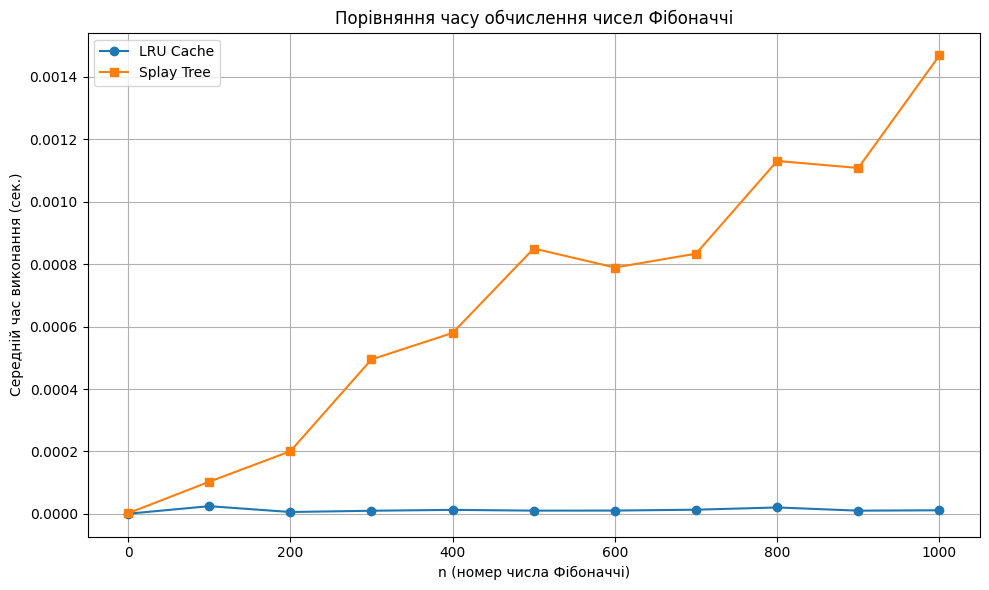

In [26]:
import timeit
import matplotlib.pyplot as plt
from functools import lru_cache
from prettytable import PrettyTable

# Реалізація Splay Tree

class Node:
    def __init__(self, key, value):
        self.key = key
        self.value = value
        self.left = None
        self.right = None

class SplayTree:
    def __init__(self):
        self.root = None

    def _rotate_right(self, x):
        y = x.left
        x.left = y.right
        y.right = x
        return y

    def _rotate_left(self, x):
        y = x.right
        x.right = y.left
        y.left = x
        return y

    def _splay(self, root, key):
        if root is None or root.key == key:
            return root

        if key < root.key:
            if root.left is None:
                return root
            if key < root.left.key:
                root.left.left = self._splay(root.left.left, key)
                root = self._rotate_right(root)
            elif key > root.left.key:
                root.left.right = self._splay(root.left.right, key)
                if root.left.right:
                    root.left = self._rotate_left(root.left)
            return root if root.left is None else self._rotate_right(root)

        else:
            if root.right is None:
                return root
            if key > root.right.key:
                root.right.right = self._splay(root.right.right, key)
                root = self._rotate_left(root)
            elif key < root.right.key:
                root.right.left = self._splay(root.right.left, key)
                if root.right.left:
                    root.right = self._rotate_right(root.right)
            return root if root.right is None else self._rotate_left(root)

    def insert(self, key, value):
        if self.root is None:
            self.root = Node(key, value)
            return

        self.root = self._splay(self.root, key)

        if self.root.key == key:
            return

        new_node = Node(key, value)
        if key < self.root.key:
            new_node.right = self.root
            new_node.left = self.root.left
            self.root.left = None
        else:
            new_node.left = self.root
            new_node.right = self.root.right
            self.root.right = None

        self.root = new_node

    def get(self, key):
        self.root = self._splay(self.root, key)
        if self.root and self.root.key == key:
            return self.root.value
        return None

# Алгоритми Фібоначчі

@lru_cache(maxsize=None)
def fibonacci_lru(n):
    if n <= 1:
        return n
    return fibonacci_lru(n-1) + fibonacci_lru(n-2)

def fibonacci_splay(n, tree):
    if n in (0, 1):
        tree.insert(n, n)
        return n
    # Ітеративне обчислення для уникнення помилки переповнення рекурсії
    a, b = 0, 1
    for i in range(2, n + 1):
        cached = tree.get(i)
        if cached is not None:
            continue
        fib_i = a + b
        tree.insert(i, fib_i)
        a, b = b, fib_i

    return tree.get(n)

# Порівняння часу
fib_numbers = list(range(0, 1001, 100))
lru_times = []
splay_times = []

for n in fib_numbers:
    lru_time = timeit.timeit(lambda: fibonacci_lru(n), number=5) / 5
    lru_times.append(lru_time)

    tree = SplayTree()
    splay_time = timeit.timeit(lambda: fibonacci_splay(n, tree), number=5) / 5
    splay_times.append(splay_time)

# Виведення результатів в таблиці
table = PrettyTable()
table.field_names = ["n", "LRU Cache Time (s)", "Splay Tree Time (s)"]

for n, lru, splay in zip(fib_numbers, lru_times, splay_times):
    table.add_row([n, f"{lru:.8f}", f"{splay:.8f}"])

print(table)

# Побудова графіка порівняння результатів
plt.figure(figsize=(10, 6))
plt.plot(fib_numbers, lru_times, marker='o', label='LRU Cache')
plt.plot(fib_numbers, splay_times, marker='s', label='Splay Tree')
plt.title("Порівняння часу обчислення чисел Фібоначчі")
plt.xlabel("n (номер числа Фібоначчі)")
plt.ylabel("Середній час виконання (сек.)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()